# Tutorial 09: Clustering and dimensionality reduction

---

## What we talked about last time
- KNN
- Logistic regression
- Overfitting: What is it? and how to avoid it?

---

## Plan for today
- Project update
- Partitioning clustering: K-Means (from scratch)
- Density based clustering (with sklearn)
- Dimensionality reduction: PCA (from scratch)

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42

---

## Data

In [2]:
n_samples_per_label = 500
samples, labels = [], []
means = [[0, 0], [-3, -3], [1, -4]]
for label, mean in enumerate(means):
    s = np.random.multivariate_normal(mean, np.eye(2), size=n_samples_per_label)
    samples.append(s)
    labels.append([label] * n_samples_per_label)
    
samples = np.concatenate(samples)
labels = np.concatenate(labels)

In [3]:
# generate colors for each unique label
colors = sns.color_palette("Set2", n_colors=len(means))

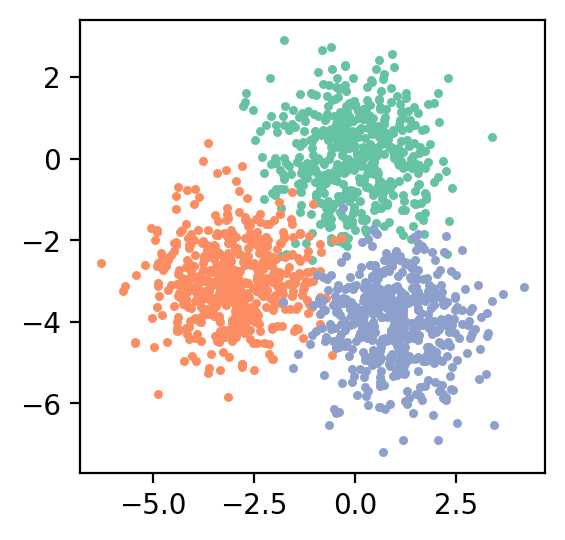

In [4]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)

for unique_label in np.unique(labels):
    ax.scatter(*samples[labels == unique_label].T, s=5, color=colors[unique_label])

## Partitioning clustering: K-Means 

### From scratch

In [5]:
def get_sample_distance_from_mean(samples, means):
    return np.sqrt(((samples[:, None, :] - means[None, ...]) ** 2).sum(axis=2))

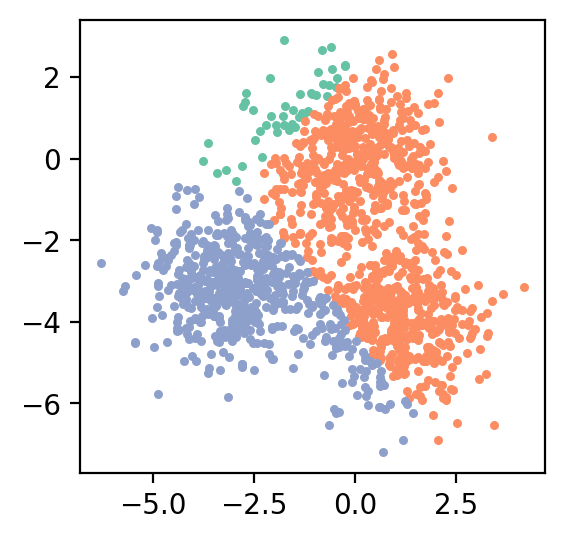

In [6]:
np.random.seed(random_seed)

k = 3
means = np.random.uniform(-6, 4, size=(k, 2))

# generate colors for each unique label
colors = sns.color_palette("Set2", n_colors=k)

# compute the distance of each sample to each mean
distances = get_sample_distance_from_mean(samples, means)

# set the labels for each sample based on their distance to the means
labels = np.argmin(distances, axis=1)

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
for unique_label in np.unique(labels):
    ax.scatter(*samples[labels == unique_label].T, s=5, color=colors[unique_label])

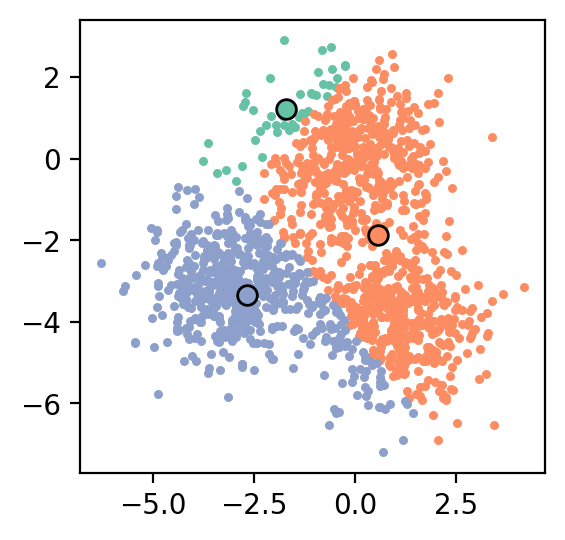

In [7]:
# compute the distance of each sample to each mean
distances = get_sample_distance_from_mean(samples, means)

# set the labels for each sample based on their distance to the means
labels = np.argmin(distances, axis=1)

# update the mean
for unique_label in np.unique(labels):
    means[unique_label] = samples[labels == unique_label].mean(axis=0)

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
for unique_label in np.unique(labels):
    ax.scatter(*samples[labels == unique_label].T, s=5, color=colors[unique_label])
    ax.scatter(*means[unique_label], s=50, color=colors[unique_label], ec='k')

### From sklearn

In [8]:
from sklearn.cluster import KMeans

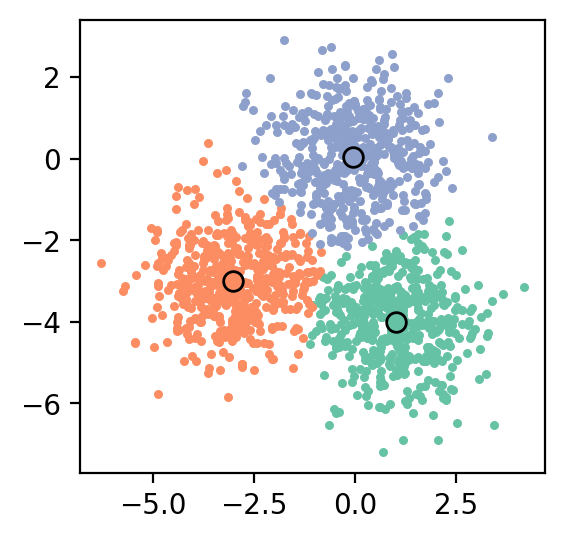

In [9]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=random_seed).fit(samples)

# generate colors for each unique label
colors = sns.color_palette("Set2", n_colors=k)

labels = kmeans.labels_
means = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
for unique_label in np.unique(labels):
    ax.scatter(*samples[labels == unique_label].T, s=5, color=colors[unique_label])
    ax.scatter(*means[unique_label], s=50, color=colors[unique_label], ec='k')

## How to choose k?

In case of K-Means, which is a non-parametric clustering method, it is clear to measure the goodness of the model on some held-out data. In other words, it is not clear what "generalization" means in clustering. Therefore, we cannot simply use methods like cross-validation to find optimal hyperparameters of our model. 

One possibility is to check how stable the clustering is: That is, to test how often two points get assigned (or not) the same cluster if you run the algorithm from different starting points.

There are also other analysis that can help finding the optimal K. Below I discuss two methods for this purpose: 1) Elbow curve and 2) Silhouette analysis.

### Method 1: Elbow curve

The elbow method computes the average distance of the points in a given cluster to the cluster mean. Let's call this qunatity **cluster distance**. <br> 
We then take the average of this quantity across all clusters.

In [10]:
ks = np.arange(2, 11)
average_distances = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_seed).fit(samples)
    labels = kmeans.labels_
    means = kmeans.cluster_centers_
    
    # compute the cluster distance
    dd = []
    for unique_label in np.unique(labels):
        d = get_sample_distance_from_mean(samples[labels == unique_label], means[[unique_label]]).mean()
        dd.append(d)
        
    average_distance = np.mean(dd)
    average_distances.append(average_distance)

When we plot the average distance versis the number of clusters we used, we then see the so-called **elbow point** (i.e. where there is an elbow-like bend in the curve). Which in this case seems to be at 3.

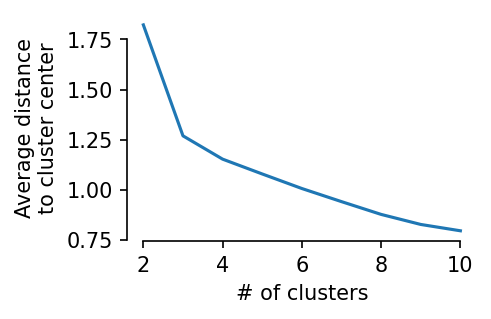

In [11]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(ks, average_distances);
ax.set(xlabel="# of clusters", ylabel="Average distance\nto cluster center")
sns.despine(trim=True)

### Method 2: Silhouette analysis

The Silhouette analysis measures the ratio between "similarity" of data points within a cluster to "similarity" of data points to the nearest cluster.

<center>
    <img src="SilhouetteScore.png" width="80%"/>
</center>

Let's create a function to compute the Silhouette score.

In [12]:
def s_score(samples, labels):
    """Computes Silhouette score givens samples and their corresponding labels."""
    s_coeffs = []
    for sample_idx, (sample, label) in enumerate(zip(samples, labels)):
        # get the other samples in a single numpy array
        other_samples_mask = np.arange(len(samples)) != sample_idx
        other_samples = samples[other_samples_mask]
        other_labels = labels[other_samples_mask]
        
        # compute the distance of the sample to other samples in the same cluster
        cohesion = get_sample_distance_from_mean(other_samples[other_labels == label], sample).mean()
        
        # compute the distance of the sample to samples from other clusters (each cluster separately)
        separations = []
        for other_unique_labels in np.unique(labels[labels != label]):
            separation = get_sample_distance_from_mean(other_samples[other_labels == other_unique_labels], sample).mean()
            separations.append(separation)
        b = min(separations)
        
        numerator = b - cohesion
        denominator = max(b, cohesion)
        s_coeff = numerator / denominator
        s_coeffs.append(s_coeff)
        
    return np.array(s_coeffs).mean()

We can also use the `silhouette_score` of sklearn package and compare the results to our implementation (to make sure we have the correct implementation).

In [13]:
from sklearn.metrics import silhouette_score

In [14]:
ks = np.arange(2, 11)
our_s_scores, sklean_s_scores = [], []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_seed).fit(samples)
    labels = kmeans.labels_
    means = kmeans.cluster_centers_
    
    # compute the score using sklearn implementation
    sklean_s_score = silhouette_score(samples, labels)
    sklean_s_scores.append(sklean_s_score)
    
    # compute the score using our implementation
    our_s_score = s_score(samples, labels)
    our_s_scores.append(our_s_score)

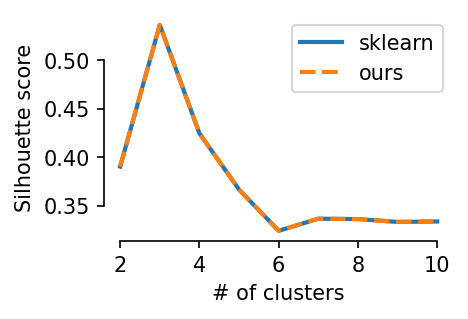

In [15]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
ax.plot(ks, sklean_s_scores, lw=2, label="sklearn")
ax.plot(ks, our_s_scores, ls="--", lw=2, label="ours")
ax.set(xlabel="# of clusters", ylabel="Silhouette score")
ax.legend()
sns.despine(trim=True)

Here again the best K seems to be 3 as K=3 achieves the highest Silhouette score. 

---

## Density based clustering: Gaussian Mixture Model (GMM)

In [16]:
from sklearn.mixture import GaussianMixture

In [17]:
n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=random_seed).fit(samples)
gmm.means_

array([[ 0.95556013, -3.95600954],
       [-3.01553144, -3.00542027],
       [-0.05473685,  0.01919444]])

In [18]:
labels = gmm.predict(samples)

In [19]:
# generate colors for each unique label
colors = sns.color_palette("Set2", n_colors=n_components)

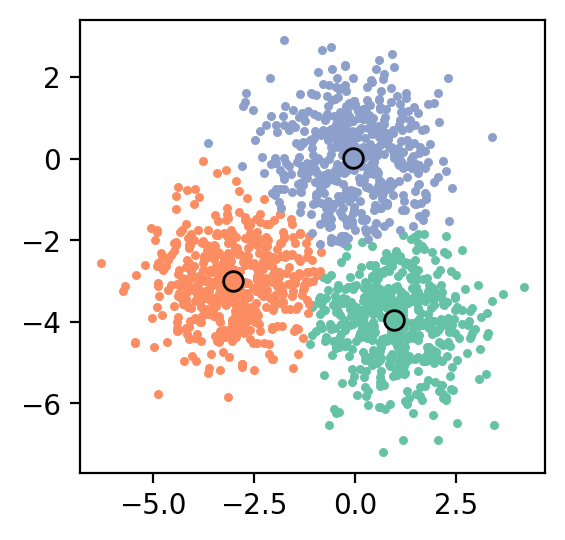

In [20]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
for unique_label in np.unique(labels):
    ax.scatter(*samples[labels == unique_label].T, s=5, color=colors[unique_label])
    ax.scatter(*gmm.means_[unique_label], s=50, color=colors[unique_label], ec='k')

### A GMM is a generative model

Since GMM learns a probability distribution over the samples, we can use this distribution to generate new samples.

In [21]:
new_samples, new_labels = gmm.sample(1000)

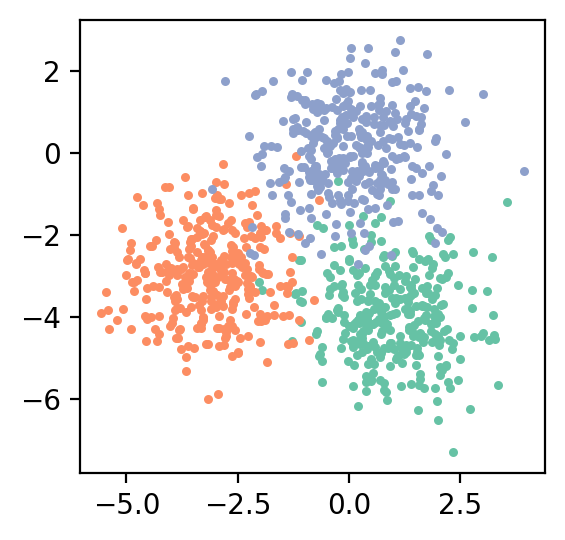

In [22]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
for unique_label in np.unique(new_labels):
    ax.scatter(*new_samples[new_labels == unique_label].T, s=5, color=colors[unique_label])

### How to choose K?

Can't we just use the same methods that we discussed for K-Means? Yes, of course. **But**..

Remember that GMM is a generative model. That means we can actually have some measure of "goodness". What is that measure? **probability**. So in this case, we can actually do cross-validation. Here is the procedure:

1. split the data into train and test samples
2. fit the GMM to the train samples
3. compute the probability of the test samples using the resulting GMM
4. do steps 1-3 for different splits of the samples (cross-validation)
5. do steps 1-4 for different number of clusters

Let's implement these steps:

In [23]:
from scipy.stats import multivariate_normal
from sklearn.model_selection import ShuffleSplit

In [24]:
def gmm_probabolity(samples, gmm):
    probs = []
    for mean, cov_mat, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        prob = multivariate_normal(mean, cov_mat).pdf(samples)
        probs.append(prob)
        
    return np.log((np.array(probs) * gmm.weights_[:, None]).sum(axis=0)).sum()

In [25]:
rs = ShuffleSplit(n_splits=5, random_state=random_seed) # 5-fold split of the data

ks = np.arange(2, 11)
train_log_probs, test_log_probs = [], []
for k in ks:
    train_log_probs_per_k, test_log_probs_per_k = [], []
    for train_indices, test_indices in rs.split(samples):
        train_samples, test_samples = samples[train_indices], samples[test_indices]
        gmm = GaussianMixture(n_components=k, random_state=random_seed).fit(train_samples)
        train_log_prob = gmm_probabolity(train_samples, gmm)
        test_log_prob = gmm_probabolity(test_samples, gmm)
        train_log_probs_per_k.append(train_log_prob)
        test_log_probs_per_k.append(test_log_prob)
        
    train_log_probs.append(train_log_probs_per_k)
    test_log_probs.append(test_log_probs_per_k)

In [26]:
train_log_probs = np.array(train_log_probs)
test_log_probs = np.array(test_log_probs)

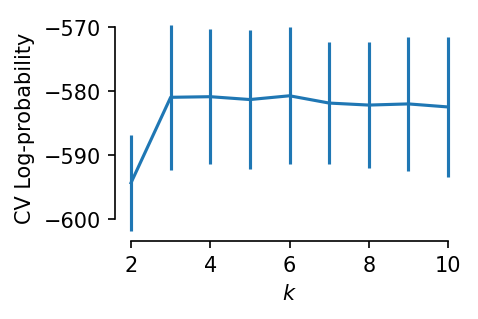

In [27]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=150)

ax.errorbar(ks, test_log_probs.mean(axis=1), yerr=test_log_probs.std(axis=1))
ax.set(xlabel=r"$k$", ylabel=r"CV Log-probability");
sns.despine(trim=True)

Here we see again that the K=3 results in the highest log-probability (also sometimes referred to as log-likelihood).

## Exercise #1

### How many clusters do you need for the following data? Use the method of your choise (K-Means or GMM)

In [28]:
from sklearn import datasets

In [29]:
samples, labels = datasets.make_moons(n_samples=500, noise=.1, random_state=random_seed)

In [30]:
# generate colors for each unique label
colors = sns.color_palette("Set2", n_colors=len(np.unique(labels)))

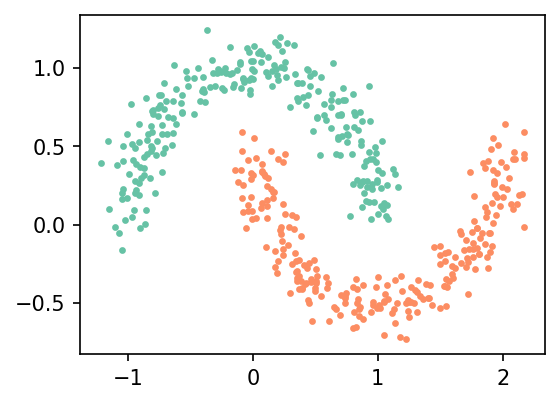

In [31]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
for unique_label in np.unique(labels):
    ax.scatter(*samples[labels==unique_label].T, s=5, color=colors[unique_label])

---

## Dimensionality reduction: PCA

In dimensionality reduction the goal is generally to find and rank important dimensions in the data. In case of PCA, the importance is characterized by "variance". That is, when doing PCA we are going to look for dimensions along which the samples have the highest variability. The first *principal component* is the dimension with the highest variance and so on. 

Once we find these PCs, it is then of interest to visualize the data along these dimensions: use the PCs as the basis vectors. This for instance, allows us to visualize a high-dimensional data (e.g. images) in a scatter plot by simply reducing the dimensionality to two dimensions. 

let's go through this process.

### Generate some sample data

In [38]:
np.random.seed(random_seed)

mean = np.array([0, 0]) #+ 10
cov_mat = np.array([[1., .6], 
                    [.6, 1.]])
n_samples = 1000

samples = np.random.multivariate_normal(mean, cov_mat, size=n_samples)

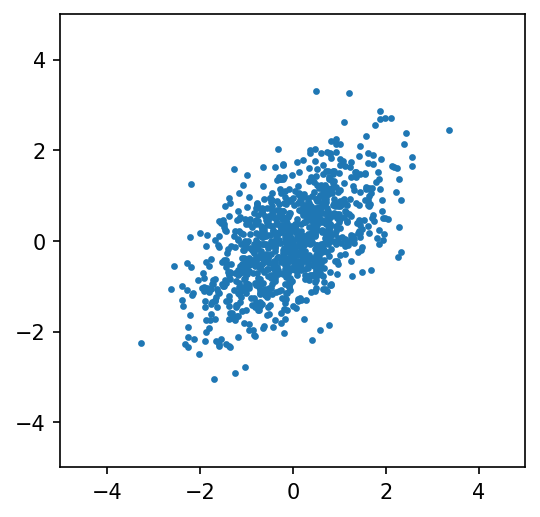

In [39]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

ax.scatter(*samples.T, s=5)
ax.set(xlim=(-5, 5), ylim=(-5, 5));

Our goal is to identify the orthognal axes/dimensions along which the data varies the most. visually, where would you draw these axes?

### The same data can be generated with scaling matrix followed by a rotation

The scaling and rotation can be found by something called the singular value decomposition:

In [40]:
r, ss, r_inv = np.linalg.svd(np.cov(samples.T))

- `r` is a rotation matrix and it is orthonormal (i.e. each column is orthogonal to other columns and each column is also a unit vector).
- `ss` contains the scaling factors we are going to use

Below we'll talk more about these matrices/factors.

In [41]:
r @ r_inv

array([[1.00000000e+00, 5.55111512e-17],
       [5.55111512e-17, 1.00000000e+00]])

In [42]:
ss

array([1.47949341, 0.41205313])

In [43]:
ss

array([1.47949341, 0.41205313])

Let's start with samples from a standard normal distribution and get to our original samples.

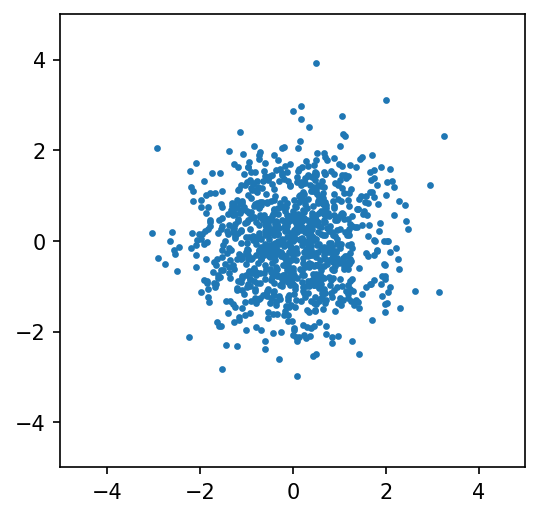

In [44]:
std_samples = np.random.randn(n_samples, 2)

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(*std_samples.T, s=5)
ax.set(xlim=(-5, 5), ylim=(-5, 5));

### Scale the data in each dimension

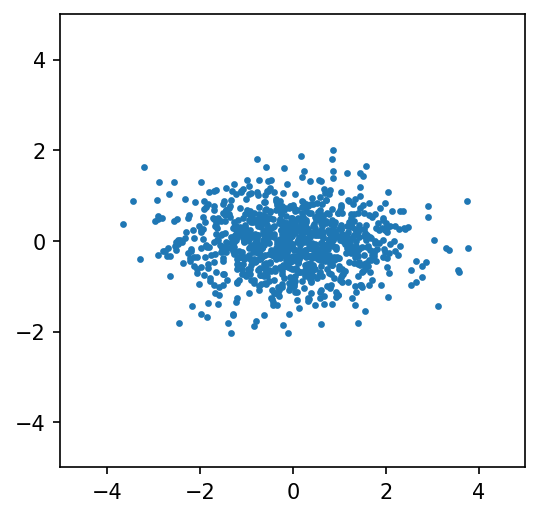

In [45]:
std_samples = np.random.randn(n_samples, 2)

scale_per_axis = np.sqrt(ss)
std_samples_transformed = (np.diag(scale_per_axis) @ std_samples.T).T

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(*std_samples_transformed.T, s=5)
ax.set(xlim=(-5, 5), ylim=(-5, 5));

### Rotate the data

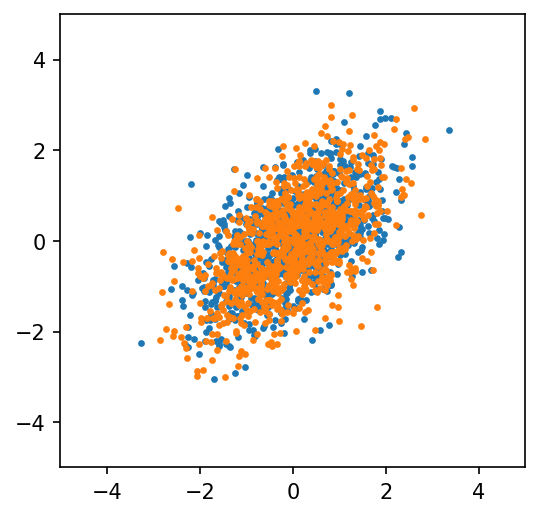

In [46]:
std_samples = np.random.randn(n_samples, 2)

std_samples_transformed = (r @ np.diag(scale_per_axis) @ std_samples.T).T

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(*samples.T, s=5)
ax.scatter(*std_samples_transformed.T, s=5)
ax.set(xlim=(-5, 5), ylim=(-5, 5));

### So what?

Well, what we just did means:
- with the rotation matrix, we have our eigen vectors: these vectors are unit vectors that define the axes along which the data varies most.
- with the scaling factors (squared) we have our eigen values which are the variance along the eigen vetors

**Note** that eigenvalues are **variances** in the direction of the corresponding eigen vector. When we scale the data along each axis we used the square-root of the eigenvalues (i.e. standard deviation).

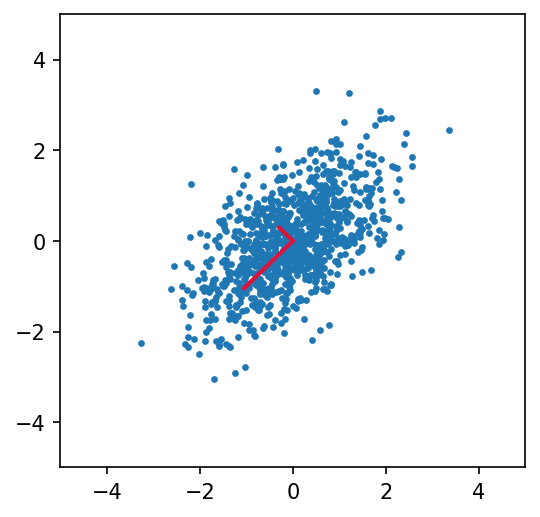

In [47]:
std_samples = np.random.randn(n_samples, 2)

std_samples_transformed = (r @ np.diag(scale_per_axis) @ std_samples.T).T

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(*samples.T, s=5)
ax.plot([0, r[0, 0] * ss[0]], [0, r[1, 0] * ss[0]], color="crimson", lw=2)
ax.plot([0, r[1, 0] * ss[1]], [0, r[1, 1] * ss[1]], color="crimson", lw=2)
ax.set(xlim=(-5, 5), ylim=(-5, 5));

### Projecting the data onto the PCs

Projecting the data is easy now - is the opposite of what we did above: now we need to inverse-transform the samples via the inverse of the rotation matrix.

What we did to go from standard normal samples to our original samples:
$$
D' = R S D_{\textrm{std}}
$$


What we do to project the data onto the PCs
$$
R^{-1}D' = S D_{\textrm{std}}
$$

**Note** that the "projected" data includes the scaling alone each PC.

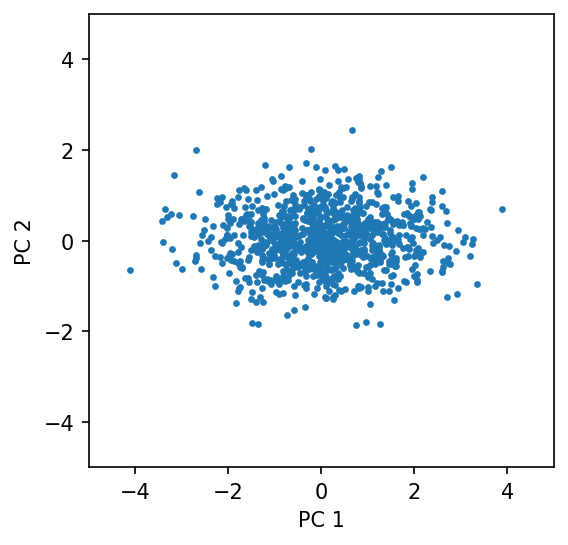

In [48]:
samples_transformed = (r_inv @ samples.T).T

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(*samples_transformed.T, s=5)
ax.set(xlim=(-5, 5), ylim=(-5, 5), xlabel="PC 1", ylabel="PC 2");

### PCA with sklearn

In [49]:
from sklearn.decomposition import PCA

In [50]:
pca = PCA(n_components=2)
pca.fit(samples)
samples_transformed = pca.transform(samples)

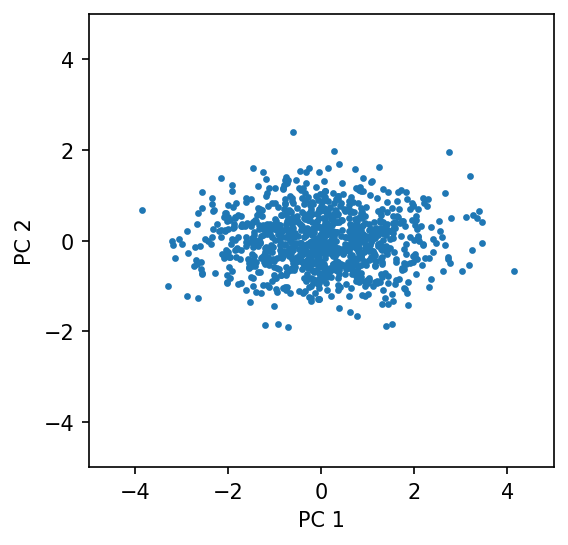

In [51]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
ax.scatter(*samples_transformed.T, s=5)
ax.set(xlim=(-5, 5), ylim=(-5, 5), xlabel="PC 1", ylabel="PC 2");

**Note** that when performing PCA as explained above, first you need to bring your data to the (0, 0) coordinate. In other words, subtract the mean along each dimension before performing PCA as explained above. Otherwise, the projection will not work properly. If you use sklearn, this is taken care of internally.

## Exercise #2

### 1. Visualize the first 5 PCs of the MNIST dataset ([link for download](https://drive.google.com/drive/folders/1HR09EbEJuhfCcKvJA0xXMDyVyMyRcuaa?usp=sharing)).

You only need to download the `mnist_train.csv` dataset.

### 2. Project the data onto the first two PCs and visualize it. 
Visualize the MNIST samples in a scatter plot where x-axis is PC1 and y-axis is PC2. Color-code each sample based on its label (i.e. number).

---